# CAIRO5 data preparation

In [1]:
#imports
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import monai
from monai.transforms import Resize
import shutil

# Set numpy print options to avoid truncation
#np.set_printoptions(threshold=np.inf)

## Testing

In [ ]:
#use first image as example

#12 and 13 are liver

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last_scans"
segmentations_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last_segmentations"

#load first image and segmentation
image = nib.load(os.path.join(scans_path, "CAESAR001_1_0000.nii.gz"))
segmentation = nib.load(os.path.join(segmentations_path, "CAESAR001_1.nii.gz"))

image_data = image.get_fdata()
segmentation_data = segmentation.get_fdata()

liver_mask = (segmentation_data == 12) | (segmentation_data == 13)

#apply mask to image
liver_image = np.copy(image_data)
liver_image[~liver_mask] = 0

# Find the indices of the liver mask
mask_indices = np.argwhere(liver_mask)

# Calculate the bounding box
min_indices = mask_indices.min(axis=0)
max_indices = mask_indices.max(axis=0)

print(min_indices, max_indices)

# Crop the liver image using the bounding box
cropped_liver_image = liver_image[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]



# # Create a new NIfTI image
new_image = nib.Nifti1Image(cropped_liver_image, affine=image.affine, header=image.header)

# # Save the new NIfTI image to a file
#output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_scans/test_liver_image.nii.gz"
nib.save(new_image, output_path)


[162 119   3] [459 349  52]


### Define all useful paths

In [2]:
# all paths 
all_scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/all_scans"
all_segmentations_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/all_segmentations"

teacher_data_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/teacher_data"
test_data_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Testing"

segmented_scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/segmented_scans"
paired_scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/paired_scans"

resized_scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/resized_scans"

## Delete scans that are in teacher

In [17]:
"""
Deletes scans from all_scans that are also in teacher_data
"""

# Get the list of scans in test_data and teacher_data
test_data_scans = set(os.listdir(test_data_path))
teacher_data_scans = set(os.listdir(teacher_data_path))
num_of_deleted = 0

# Iterate through all scans in all_scans_path
for scan in os.listdir(all_scans_path):
    scan_id = (scan.split(".")[0])[0:-5] + ".nii.gz"
    # Check if the scan exists in either test_data or teacher_data
    if scan_id in teacher_data_scans:
        # Delete the scan from all_scans_path
        os.remove(os.path.join(all_scans_path, scan))
        print(f"Deleted scan: {scan}")
        num_of_deleted += 1

print(f"Number of deleted scans: {num_of_deleted}")

Deleted scan: CAESAR151_1_0000.nii.gz
Deleted scan: CAESAR211_1_0000.nii.gz
Deleted scan: CAESAR188_1_0000.nii.gz
Deleted scan: CAESAR088_0_0000.nii.gz
Deleted scan: CAESAR133_0_0000.nii.gz
Deleted scan: CAESAR215_1_0000.nii.gz
Deleted scan: CAESAR028_1_0000.nii.gz
Deleted scan: CAESAR088_1_0000.nii.gz
Deleted scan: CAESAR011_2_0000.nii.gz
Deleted scan: CAESAR178_0_0000.nii.gz
Deleted scan: CAESAR178_1_0000.nii.gz
Deleted scan: CAESAR215_0_0000.nii.gz
Deleted scan: CAESAR126_0_0000.nii.gz
Deleted scan: CAESAR111_0_0000.nii.gz
Deleted scan: CAESAR195_1_0000.nii.gz
Deleted scan: CAESAR202_1_0000.nii.gz
Deleted scan: CAESAR133_1_0000.nii.gz
Deleted scan: CAESAR111_1_0000.nii.gz
Deleted scan: CAESAR036_1_0000.nii.gz
Deleted scan: CAESAR079_1_0000.nii.gz
Deleted scan: CAESAR188_0_0000.nii.gz
Deleted scan: CAESAR161_0_0000.nii.gz
Deleted scan: CAESAR057_0_0000.nii.gz
Deleted scan: CAESAR168_0_0000.nii.gz
Deleted scan: CAESAR202_0_0000.nii.gz
Deleted scan: CAESAR022_2_0000.nii.gz
Deleted scan

## Delete scans with missing segmentations  

In [18]:
"""
Checks which scans do not have corresponding segmentations
"""

# Initialize a list to store scans without segmentations
scans_without_segmentation = []

# Iterate through all scans
for scan in os.listdir(all_scans_path):
    name = (scan.split(".")[0])[0:-5]
    has_segmentation = False

    # Check if a corresponding segmentation exists
    for segm in os.listdir(all_segmentations_path):
        if name in segm:
            has_segmentation = True
            break

    # If no segmentation is found, add the scan to the list
    if not has_segmentation:
        scans_without_segmentation.append(scan)

# Print the scans without segmentations
print("Scans without segmentations:", scans_without_segmentation)

Scans without segmentations: ['filenames.txt']


The above scans are removed from the folder "all_scans"

## Segment liver and apply bounding box

In [20]:
"""
Segments the liver and applies a bounding box 
"""


for scan in os.listdir(all_scans_path):
    print(f"currently processing: {scan}")
    
    #load image and corresponding segmentation
    image = nib.load(os.path.join(all_scans_path, scan))

    segm_filename = scan.replace("_0000", "")
    segmentation = nib.load(os.path.join(all_segmentations_path, segm_filename))

    image_data = image.get_fdata()
    segmentation_data = segmentation.get_fdata()

    liver_mask = (segmentation_data == 12) | (segmentation_data == 13)

    #apply mask to image
    liver_image = np.copy(image_data)
    liver_image[~liver_mask] = 0

    # Find the indices of the liver mask
    mask_indices = np.argwhere(liver_mask)

    # Calculate the bounding box
    min_indices = mask_indices.min(axis=0)
    max_indices = mask_indices.max(axis=0)

    # Crop the liver image using the bounding box
    cropped_liver_image = liver_image[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]

    # Create a new NIfTI image
    new_image = nib.Nifti1Image(cropped_liver_image, affine=image.affine, header=image.header)

    # Save the new NIfTI image to a file with the original name
    new_filename = (scan.split(".")[0])[0:-5] + ".nii.gz"
    output_file_path = os.path.join(segmented_scans_path, new_filename)
    nib.save(new_image, output_file_path)


currently processing: CAESAR326_1_0000.nii.gz
currently processing: CAESAR187_0_0000.nii.gz
currently processing: CAESAR360_1_0000.nii.gz
currently processing: CAESAR357_1_0000.nii.gz
currently processing: CAESAR012_1_0000.nii.gz
currently processing: CAESAR429_1_0000.nii.gz
currently processing: CAESAR453_1_0000.nii.gz
currently processing: CAESAR442_0_0000.nii.gz
currently processing: CAESAR569_1_0000.nii.gz
currently processing: CAESAR257_2_0000.nii.gz
currently processing: CAESAR226_0_0000.nii.gz
currently processing: CAESAR583_0_0000.nii.gz
currently processing: CAESAR419_0_0000.nii.gz
currently processing: CAESAR537_0_0000.nii.gz
currently processing: CAESAR269_1_0000.nii.gz
currently processing: CAESAR372_0_0000.nii.gz
currently processing: CAESAR404_1_0000.nii.gz
currently processing: CAESAR512_1_0000.nii.gz
currently processing: CAESAR417_1_0000.nii.gz
currently processing: CAESAR001_1_0000.nii.gz
currently processing: CAESAR299_0_0000.nii.gz
currently processing: CAESAR463_2_

## Subset 0 & 1 scans

In [21]:
"""
copies scans of patients that have both 0 and 1 scans
"""

# Create a dictionary to track patient scans
patient_scans = {}

# Iterate through all scans
for scan in os.listdir(segmented_scans_path):
    # Extract the patient ID and scan type (0 or 1)

    patient_id, scan_type = scan.split("_")[0], scan[0:-7].split("_")[1]

    # Add the scan type to the patient's record
    if patient_id not in patient_scans:
        patient_scans[patient_id] = set()
    patient_scans[patient_id].add(scan_type)

# Move scans of patients that have both 0 and 1 scans
for patient_id, scan_types in patient_scans.items():
    if "0" in scan_types and "1" in scan_types:
        first_scan = f"{patient_id}_0.nii.gz"
        second_scan = f"{patient_id}_1.nii.gz"
        shutil.copy(os.path.join(segmented_scans_path, first_scan), os.path.join(paired_scans_path, first_scan))
        shutil.copy(os.path.join(segmented_scans_path, second_scan), os.path.join(paired_scans_path, second_scan))

## Resize scans

In [ ]:



# Define the desired size
#(depth, height, width)
desired_size = (300, 300, 100)

# Initialize the Monai Resize transform
resize_transform = Resize(spatial_size=desired_size, mode="linear")

# Iterate through all scans in the paired scans folder
for scan in os.listdir(paired_scans_path):
    print(f"Resizing: {scan}")
    
    # Load the scan
    image = nib.load(os.path.join(paired_scans_path, scan))
    image_data = image.get_fdata()

    # Add a channel dimension if missing
    if len(image_data.shape) == 3:  # Shape is [H, W, D]
        image_data = image_data[None, ...]  # Add a channel dimension: [1, H, W, D]
    
    # Apply the resize transform
    resized_image_data = resize_transform(image_data)
    
    # Remove the channel dimension after resizing
    resized_image_data = resized_image_data[0]  # Remove channel dimension: [H, W, D]

    # Create a new NIfTI image
    resized_image = nib.Nifti1Image(resized_image_data, affine=image.affine, header=image.header)
    resized_image_path = os.path.join(resized_scans_path, scan)

    # Save the resized image
    nib.save(resized_image, resized_image_path)

Resizing: CAESAR082_0.nii.gz
Original shape: (309, 225, 87)
Added channel dimension: (1, 309, 225, 87)
Resized shape (with channel): torch.Size([1, 300, 300, 100])
Resized shape (without channel): torch.Size([300, 300, 100])


### Distribution of number of slices

In [ ]:
#distribution of slices
scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last_scans"

max_slices = 0

number_of_slices = []
for scan in os.listdir(scans_path):
    image = nib.load(os.path.join(scans_path, scan))
    image_shape = image.header.get_data_shape()
    max_slices = max(max_slices, image_shape[2])    
    if image_shape[2] < 150:
        number_of_slices.append(image_shape[2])

print(f"Max number of slices {max_slices}")
plt.hist(number_of_slices)
plt.show() 

328
376


### Create segmentation and bounding box

In [ ]:
"""
Segments the liver and apply bounding box 
"""

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last_scans"
segmentations_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last_segmentations"
output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_scans"

max_dimensions = [0, 0, 0]

for scan in os.listdir(scans_path):
    print(scan)
    
    #load image and corresponding segmentation
    image = nib.load(os.path.join(scans_path, scan))

    segm_filename = scan.replace("_0000", "")
    segmentation = nib.load(os.path.join(segmentations_path, segm_filename))

    image_data = image.get_fdata()
    segmentation_data = segmentation.get_fdata()

    liver_mask = (segmentation_data == 12) | (segmentation_data == 13)

    #apply mask to image
    liver_image = np.copy(image_data)
    liver_image[~liver_mask] = 0

    # Find the indices of the liver mask
    mask_indices = np.argwhere(liver_mask)

    # Calculate the bounding box
    min_indices = mask_indices.min(axis=0)
    max_indices = mask_indices.max(axis=0)

    # Crop the liver image using the bounding box
    cropped_liver_image = liver_image[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
    
    # Update the maximum dimensions
    max_dimensions = np.maximum(max_dimensions, cropped_liver_image.shape)

    # Create a new NIfTI image
    new_image = nib.Nifti1Image(cropped_liver_image, affine=image.affine, header=image.header)

    # Save the new NIfTI image to a file with the original name
    new_filename = scan.split(".")[0] + "_cropped.nii.gz"
    output_file_path = os.path.join(output_path, new_filename)
    nib.save(new_image, output_file_path)

print(f"max dimensions: {max_dimensions}")

### Distribution of dimension sizes

In [ ]:
"""
Checks the shape of every scan and print the max number of slices
"""
scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_scans"

first_dim = []
second_dim = []
third_dim = []
max_slices = 0

for scan in os.listdir(scans_path):
    image = nib.load(os.path.join(scans_path, scan))
    image_data = image.get_fdata()
    first_dim.append(image_data.shape[0])
    second_dim.append(image_data.shape[1])
    third_dim.append(image_data.shape[2])

print(f"Max number of slices: {max(third_dim)}")


366


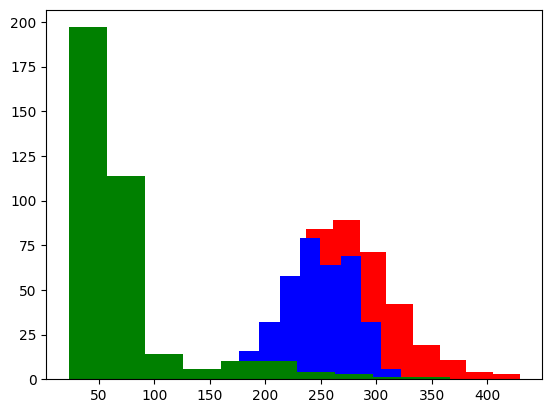

In [42]:
plt.hist(first_dim, color='red')
plt.hist(second_dim, color='blue')
plt.hist(third_dim, color='green')
plt.show()

## Sanity checks

In [ ]:
"""
Check if all scans in a folder have the same size
"""

# Path to the folder containing padded and/or downsized liver segmentations
path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/padded_liver_scans"
#path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/downsized_padded_liver_scans"


# Initialize a variable to store the shape of the first image
reference_shape = None
all_same_size = True

# Iterate through all files in the folder
for scan in os.listdir(path):
    # Load the image
    image = nib.load(os.path.join(padded_segm_path, scan))
    image_data = image.get_fdata()
    
    # Get the shape of the current image
    current_shape = image_data.shape
    
    # If reference_shape is None, set it to the shape of the first image
    if reference_shape is None:
        reference_shape = current_shape
    else:
        # Compare the shape of the current image with the reference shape
        if current_shape != reference_shape:
            all_same_size = False
            print(f"Image {scan} has a different size: {current_shape}")
            break

if all_same_size:
    print("All images have the same size.")
else:
    print("Not all images have the same size.")

All images have the same size.


In [ ]:
#write check to see if 0&1 is correct